# Company 1: BRUKER CORP -  ML Process

Decision to go with a logistic regression, predicting whether the share price will increase or decrease, based on the share prices of the past 4 days.

This notebook is organized in the following sections:
* [Step 0 - Preliminary: Load the clean csv](#0)
* [Step 1 - Remodel dataset](#1)
* [Step 2 - Data Analysis](#2)
* [Step 3 - Imputing/dropping missing values](#3)
* [Step 4 - Ensuring Correct Datatypes](#4)
* [Step 5 - Preparation for merging](#5)


<a id='0'></a>
## Step 0 - Preliminary: Load the clean csv

In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [65]:
prices_bruker = pd.read_csv("/Users/camillaperotti/Desktop/IE/Courses MBD/Term 2/PDA II/00_GroupProject/mbd-python-tradingsystem/ETL/pricesbruker_output.csv")

In [66]:
prices_bruker.drop(columns=['Unnamed: 0'], inplace=True)

In [67]:
prices_bruker

,Ticker,SimFinId,Date,Open,High,Low,Close,Adj. Close,Volume,Dividend,Shares Outstanding
0,BRKR,1253240,2019-04-01,38.76,39.01,38.47,38.87,38.20,761845,0.00,156814676
1,BRKR,1253240,2019-04-02,38.94,39.01,38.39,38.53,37.86,666801,0.00,156814676
2,BRKR,1253240,2019-04-03,38.74,39.24,38.63,39.01,38.33,2647355,0.00,156814676
3,BRKR,1253240,2019-04-04,38.95,39.01,37.82,38.32,37.66,503730,0.00,156814676
4,BRKR,1253240,2019-04-05,38.41,39.23,38.30,38.41,37.74,509516,0.00,156814676
...,...,...,...,...,...,...,...,...,...,...,...
1234,BRKR,1253240,2024-02-26,84.34,84.88,83.21,83.60,83.35,788986,0.00,137671143
1235,BRKR,1253240,2024-02-27,83.60,84.29,83.05,83.70,83.45,559922,0.00,137671143
1236,BRKR,1253240,2024-02-28,84.18,87.25,84.13,86.48,86.23,1433649,0.00,137671143
1237,BRKR,1253240,2024-02-29,86.90,88.92,85.86,86.54,86.33,2687003,0.05,137671143


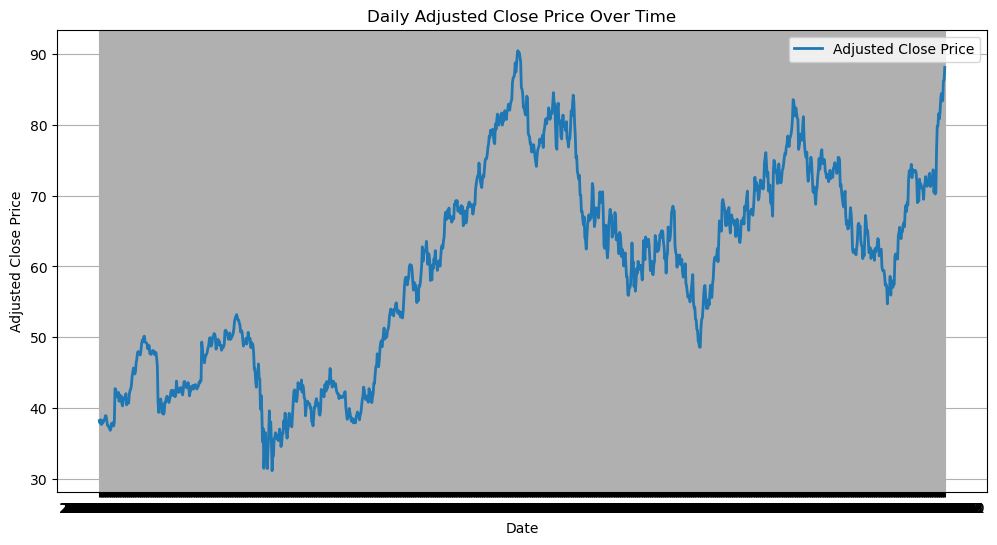

In [68]:
import matplotlib.pyplot as plt

# Plot the Adjusted Close Price as a time series
plt.figure(figsize=(12, 6))
plt.plot(prices_bruker['Date'], prices_bruker['Adj. Close'], label='Adjusted Close Price', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Daily Adjusted Close Price Over Time')
plt.legend()
plt.grid(True)
#plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.show()

<a id='1'></a>
## Step 1 - Dataset preparation

We will work only with prices of the last 5 days to predict 

In [69]:
# Ensure data is sorted by date
prices_bruker = prices_bruker.sort_values("Date").reset_index(drop=True)

# Drop all unwanted columns
prices_bruker.drop(columns=["Ticker","SimFinId","Open","High", "Low", "Close", "Volume", "Dividend","Shares Outstanding"],inplace = True)

# Rename adjusted close column

prices_bruker.rename(columns={"Adj. Close": "Price"}, inplace= True)

Let's add the last 4 days' prices into the df:

In [70]:
days = 4

for day in range(1, days + 1):
    prices_bruker[f"Price d-{day}"] = prices_bruker["Price"].shift(day)

In [71]:
#dropping first rows with missing values

prices_bruker = prices_bruker.dropna()

In [72]:
prices_bruker.head()

,Date,Price,Price d-1,Price d-2,Price d-3,Price d-4
4,2019-04-05,37.74,37.66,38.33,37.86,38.20
5,2019-04-08,38.16,37.74,37.66,38.33,37.86
6,2019-04-09,37.98,38.16,37.74,37.66,38.33
7,2019-04-10,38.33,37.98,38.16,37.74,37.66
8,2019-04-11,38.41,38.33,37.98,38.16,37.74


Add the target variable (1: tomorrow's price goes up, 0: price goes down or stays the same):

In [73]:
prices_bruker["Price_Up"] = (prices_bruker["Price"].shift(-1) > prices_bruker["Price"]).astype(int)

Dropping last row as it has no "next day" to compare to:

In [74]:
prices_bruker = prices_bruker.drop(index=1238)

The dataset is now ready to be used for the logistic regression.

In [79]:
prices_bruker

,Date,Price,Price d-1,Price d-2,Price d-3,Price d-4,Price_Up
4,2019-04-05,37.74,37.66,38.33,37.86,38.20,1
5,2019-04-08,38.16,37.74,37.66,38.33,37.86,0
6,2019-04-09,37.98,38.16,37.74,37.66,38.33,1
7,2019-04-10,38.33,37.98,38.16,37.74,37.66,1
8,2019-04-11,38.41,38.33,37.98,38.16,37.74,1
...,...,...,...,...,...,...,...
1233,2024-02-23,84.42,83.49,81.68,80.86,81.58,0
1234,2024-02-26,83.35,84.42,83.49,81.68,80.86,1
1235,2024-02-27,83.45,83.35,84.42,83.49,81.68,1
1236,2024-02-28,86.23,83.45,83.35,84.42,83.49,1


Check if dataset is balanced:

In [78]:
prices_bruker["Price_Up"].value_counts() / len(prices_bruker)

Price_Up
1    0.519449
0    0.480551
Name: count, dtype: float64

Conclusion: The dataset is balanced. Let's visualize our features and target.
- Features: all prices of last 5 days
- Target variable: Prediction if price will rise (1) or fall / remain the same (0)

In [ ]:
#visualization perhaps ?

<a id='1'></a>
## Step 1 - Data Analysis